In [ ]:
%pip install 

In [2]:
import os
import pandas as pd
from pathlib import Path

#from jsonschema.benchmarks.contains import beginning

Nr 
Panel 
1. 
Copper Indium Gallium Selenide (CIGS), a flexible 
module; 
nominal efficiency Specifications 
12.7% specs 
2. 
Cadmium Telluride (CdTe), a lower cost module; 
12.0% specs 
3. 
Polycrystalline Silicon (Poly-Si), the most commonly 
used technology; 
15.5% specs 
4. 
Interdigitated Back Contact monocrystalline silicon, 
charge extraction located at the back of the cell;  
21.5% specs 
5. 
Heterojunction Intrinsic Layer Monocrystalline Silicon 
(HIT Si), highest lab-tested efficiency; 
19.4% specs 
6. 
Copper Indium Gallium Selenide (CIGS) with reflective 
backing; 
14.7% specs

In [4]:
def get_selected_months(years=None, months=None):
    """
    Generate a list of selected months based on user input for years and months.
    
    Parameters:
        years (list of int): List of years to include (e.g., [2017, 2018]).
        months (list of int): List of months to include (e.g., [1, 2, 3]).
        
    Returns:
        list of str: List of selected year_month combinations (e.g., ['2017_01', '2017_02']).
    """
    if years is None:
        years = [2017]  # Default year
    if months is None:
        months = range(1, 13)  # Default to all months

    selected_months = [f"{year}_{str(month).zfill(2)}" for year in years for month in months]
    return selected_months

In [60]:
def load_and_sync_data(base_path, selected_months, selected_csvs, debug=False):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise FileNotFoundError(f"The base path does not exist: {base_path}")

    # Dictionary to store DataFrames from each source
    source_dataframes = {}

    for csv_type in selected_csvs:
        combined_source_data = []

        for month in selected_months:
            year, month_number = month.split('_')
            year_folder = f"{year}_V3"
            month_folder = f"{year}_{month_number}"
            month_path = base_path / year_folder / month_folder

            if not month_path.is_dir():
                if debug:
                    print(f"Skipping non-existent directory: {month_path}")
                continue

            # Determine the correct file name for the source
            file_name_with_space = f"{csv_type}- {month_folder}.csv"
            file_name_without_space = f"{csv_type}-{month_folder}.csv"

            file_path = None
            if csv_type == "LightSpectra":
                # Handle LightSpectra's unique naming format
                file_path_with_space = month_path / file_name_with_space
                file_path_without_space = month_path / file_name_without_space
                if file_path_with_space.exists():
                    file_path = file_path_with_space
                elif file_path_without_space.exists():
                    file_path = file_path_without_space
            else:
                file_path = month_path / file_name_without_space

            if file_path and file_path.exists():
                try:
                    data_frame = pd.read_csv(file_path, low_memory=False)

                    # -------------------
                    # Standardize date/time columns
                    # -------------------
                    data_frame["Year"] = data_frame.get("Date[year]", year)
                    data_frame["Month"] = data_frame.get("Date[month]", month_number)
                    data_frame["Day"] = data_frame.get("Date[day]")
                    data_frame["Weekday"] = data_frame.get("Date[weekday]")

                    if "Time[hh:mm:ss]" in data_frame.columns:
                        data_frame["Time"] = data_frame["Time[hh:mm:ss]"]
                        data_frame.drop(columns=["Time[hh:mm:ss]"], errors="ignore", inplace=True)

                    data_frame.drop(
                        columns=[col for col in data_frame.columns if col.startswith("Date[")],
                        errors="ignore",
                        inplace=True
                    )

                    data_frame["Source"] = csv_type  # (optional metadata)
                    combined_source_data.append(data_frame)

                except Exception as e:
                    if debug:
                        print(f"Error loading file {file_path}: {e}")
            else:
                if debug:
                    print(f"File not found: {file_path}")

        # Concatenate all data for the current source
        if combined_source_data:
            source_dataframes[csv_type] = pd.concat(combined_source_data, ignore_index=True)

    # -------------------
    # Merge (inner join) across all sources on "AbsTime[s]"
    # -------------------
    synced_data = None
    for source, df in source_dataframes.items():
        if synced_data is None:
            synced_data = df
        else:
            synced_data = pd.merge(
                synced_data,
                df,
                on='AbsTime[s]',
                how='inner',
                suffixes=('', f'_{source}')
            )

    # -------------------
    # Consolidate duplicate columns
    # -------------------
    if synced_data is not None:
        for col in ["Year", "Month", "Day", "Time", "Weekday"]:
            # Gather all columns that start with "Year", "Month", etc.
            cols_to_merge = [c for c in synced_data.columns if c.startswith(col)]
            if len(cols_to_merge) > 1:
                # Fill "master" col with first non-NaN going left->right
                synced_data[col] = synced_data[cols_to_merge].bfill(axis=1).iloc[:, 0]
                # Drop duplicates except for the original "col"
                cols_to_drop = [c for c in cols_to_merge if c != col]
                synced_data.drop(columns=cols_to_drop, inplace=True, errors="ignore")

        # Remove the "Source" columns if no longer needed
        synced_data.drop(
            columns=[col for col in synced_data.columns if "Source" in col],
            errors="ignore",
            inplace=True
        )

        # Remove exact duplicated columns (rare leftover edge case)
        synced_data = synced_data.loc[:, ~synced_data.columns.duplicated()]

        return synced_data

    # If no data was found at all
    return pd.DataFrame()


if __name__ == "__main__":
    # Base path to the dataset
    base_path = "../../OneDrive - HvA/Jaar_4/PV systems modeling and analysis/Data/data_folder"
    base_path_bono = "../../school/4e jaar/PV systems modeling and analysis/Data/data_folder"

    # Specify months and sources to include
    selected_months = get_selected_months(years=[2021], months=[1,2,3,4,5,6,7,8,9,10,11,12])
    selected_csvs = ["SolarFieldData", "IVCurves"]

    # Load and synchronize data
    synced_df = load_and_sync_data(base_path, selected_months, selected_csvs, debug=True)

    # Display the synchronized DataFrame
    print("\nSynchronized DataFrame:")
    print(synced_df.head())

    # # Save the synchronized data for later use (optional)
    # synced_df.to_csv("synced_data_january_2017_2018.csv", index=False)
    # print("Synchronized data saved to synced_data_january_2017_2018.csv")



Synchronized DataFrame:
   AbsTime[s]  Act Air Density (WeatherStation)  \
0  3818448000                               NaN   
1  3818448300                               NaN   
2  3818448600                               NaN   
3  3818448900                               NaN   
4  3818449200                               NaN   

   Act Wind Direction (WeatherStation)  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

   Act Wind Measurement Quality (WeatherStation)  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   Act Wind Speed [km/h] (WeatherStation)  \
0                                     NaN   
1           

In [61]:
synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,I list[A]_4 (Solarpanel curves),average G [W/m²]_4 (Solarpanel curves),Module #_5 (Solarpanel curves),V list[V]_5 (Solarpanel curves),I list[A]_5 (Solarpanel curves),average G [W/m²]_5 (Solarpanel curves),Module #_6 (Solarpanel curves),V list[V]_6 (Solarpanel curves),I list[A]_6 (Solarpanel curves),average G [W/m²]_6 (Solarpanel curves)
0,3818448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3818448300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3818448600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3818448900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3818449200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,3849982500,1.240187,353.64890,100.0,2.636794,1022.793,12.80436,10.39158,85.31494,3.039458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105116,3849982800,1.240346,335.42040,100.0,0.000000,1022.786,12.78799,10.38807,85.37498,2.147286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105117,3849983100,1.240697,23.92803,100.0,3.682065,1022.931,12.71630,10.31993,85.35741,2.162874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105118,3849983400,1.240589,226.87920,100.0,4.152539,1022.825,12.66590,10.27172,85.40105,1.785807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


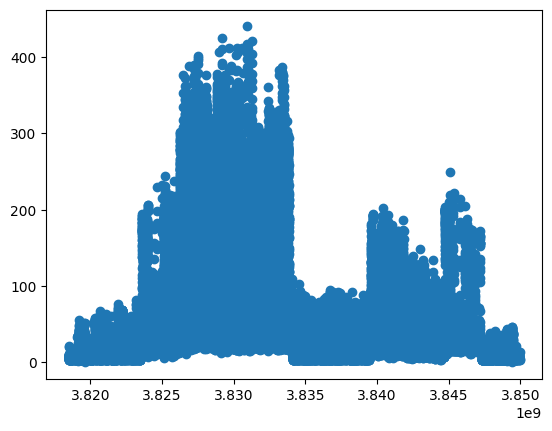

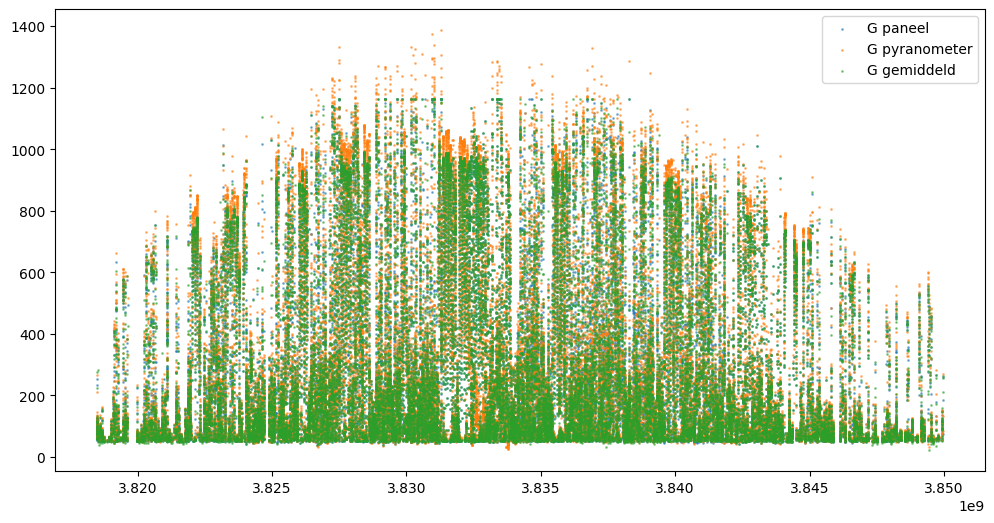

In [74]:
import matplotlib.pyplot as plt
plt.scatter(synced_df['AbsTime[s]'], synced_df['Pmpp[W]_3 (Solarpanel parameters)'])
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(synced_df['AbsTime[s]'], synced_df['G[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1)

plt.scatter(synced_df['AbsTime[s]'], synced_df['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1)

plt.scatter(synced_df['AbsTime[s]'], synced_df['average G [W/m²]_3 (Solarpanel curves)'],alpha=0.5, s=1)
#legend
plt.legend(['G paneel', 'G pyranometer', 'G gemiddeld'])
plt.show()

In [75]:
# 1) Maandnaam omzetten naar maandnummer
month_map = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}
synced_df['Month_num'] = synced_df['Month'].map(month_map)

# 2) De kolommen Year, Month_num, Day en Time samenvoegen tot een datumstring
synced_df['datetime_str'] = (
    synced_df['Year'].astype(str) + '-' +
    synced_df['Month_num'].astype(str) + '-' +
    synced_df['Day'].astype(str) + ' ' +
    synced_df['Time'].astype(str)
)

# 3) Deze string parsen naar een datetime-kolom
synced_df['datetime'] = pd.to_datetime(synced_df['datetime_str'], format='%Y-%m-%d %H:%M:%S')

# 4) Zet deze nieuwe kolom als index van je DataFrame
synced_df.set_index('datetime', inplace=True)

# 5) (Optioneel) Opruimen: als je de losse kolommen niet meer nodig hebt:
synced_df.drop(columns=['Month_num', 'datetime_str'], inplace=True)

synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,I list[A]_4 (Solarpanel curves),average G [W/m²]_4 (Solarpanel curves),Module #_5 (Solarpanel curves),V list[V]_5 (Solarpanel curves),I list[A]_5 (Solarpanel curves),average G [W/m²]_5 (Solarpanel curves),Module #_6 (Solarpanel curves),V list[V]_6 (Solarpanel curves),I list[A]_6 (Solarpanel curves),average G [W/m²]_6 (Solarpanel curves)
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,3818448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:05:00,3818448300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:10:00,3818448600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:15:00,3818448900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:20:00,3818449200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,3849982500,1.240187,353.64890,100.0,2.636794,1022.793,12.80436,10.39158,85.31494,3.039458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 23:40:00,3849982800,1.240346,335.42040,100.0,0.000000,1022.786,12.78799,10.38807,85.37498,2.147286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 23:45:00,3849983100,1.240697,23.92803,100.0,3.682065,1022.931,12.71630,10.31993,85.35741,2.162874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# AbsTime[s],
# Act Air Density (WeatherStation),
# Act Wind Direction (WeatherStation),
# Act Wind Measurement Quality (WeatherStation),
# Act Wind Speed [km/h] (WeatherStation),
# Avg Absolute Air Pressure (WeatherStation),
# Avg Air Temperature (WeatherStation),
# Avg Dewpoint Temperature (WeatherStation),
# Avg Relative Humidity (WeatherStation),
# Avg Wind Speed [km/h] (WeatherStation),
# Precipitation Intensity [mm/h] (WeatherStation),
# Precipitation Type (WeatherStation),
# Module #_1 (Solarpanel parameters),
# Vmpp[V]_1 (Solarpanel parameters),
# Impp[A]_1 (Solarpanel parameters),
# Pmpp[W]_1 (Solarpanel parameters),
# Voc[V]_1 (Solarpanel parameters),
# Isc[A]_1 (Solarpanel parameters),
# FF[%]_1 (Solarpanel parameters),
# G[W/mï½²]_1 (Solarpanel parameters),
# Tmodul[ï½°C]_1 (Solarpanel parameters),
# G_pyranometer[W/mï½²]_1 (Solarpanel parameters),
# V Range_1 (Solarpanel parameters),
# I Range_1 (Solarpanel parameters),
# Scan Rate[S/sec.]_1 (Solarpanel parameters),
# Observed Efficiency_1 (Solarpanel parameters),
# Year,Month,Day,Weekday,Time

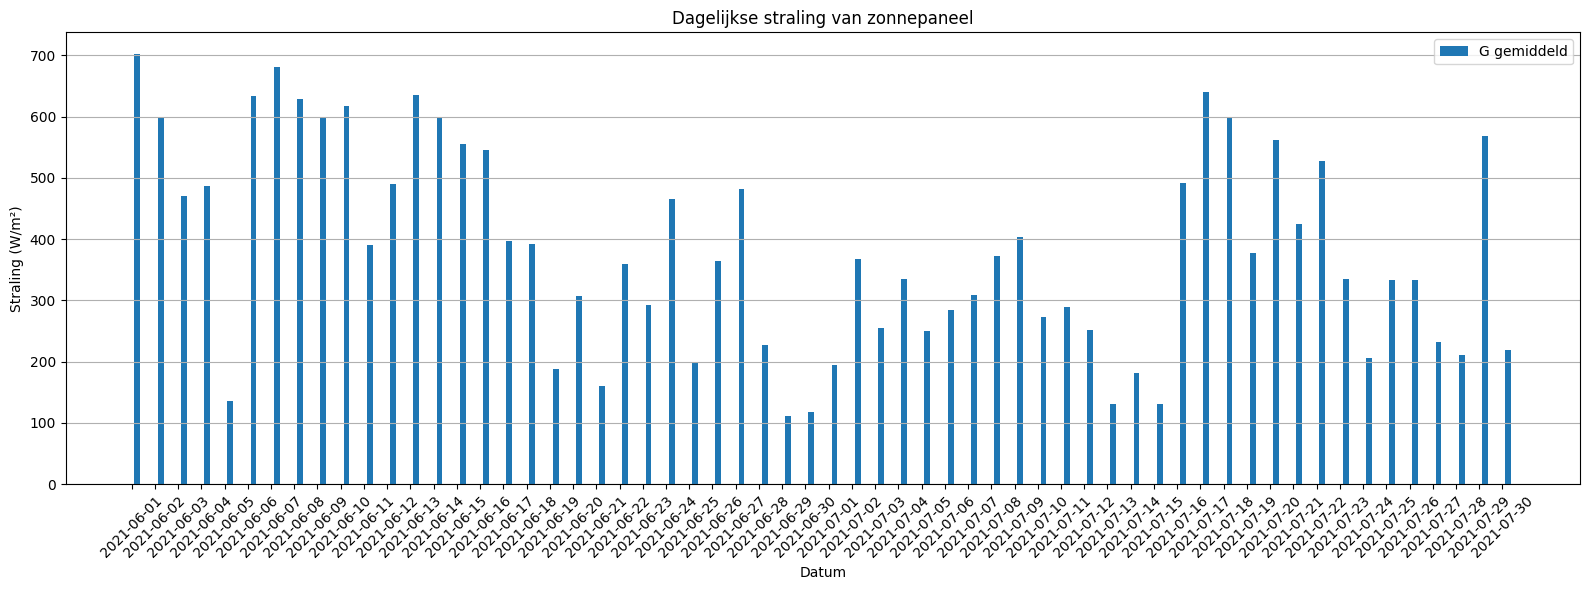

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

begin = pd.Timestamp('2021-06-01')
end = pd.Timestamp('2021-07-30')

# Select only numeric columns
numeric_columns = synced_df.select_dtypes(include=['number'])

# Aggregate data to daily averages using only numeric columns
daily_data = numeric_columns.resample('D').mean()

# Filter the daily data for the given date range
filtered_daily_data = daily_data[(daily_data.index >= begin) & (daily_data.index <= end)]

# Define the variables to plot
variables = [
    'G[W/m²]_3 (Solarpanel parameters)',
    'G_pyranometer[W/m²]_3 (Solarpanel parameters)',
    'average G [W/m²]_3 (Solarpanel curves)'
]

# Define labels for the legend
labels = ['G paneel', 'G pyranometer', 'G gemiddeld']

# Bar width and offsets
bar_width = 0.25
x = range(len(filtered_daily_data.index))

plt.figure(figsize=(16, 6))

# Create bars for each variable
for i, var in enumerate(variables):
    if var in filtered_daily_data.columns:
        plt.bar(
            [p + i * bar_width for p in x],
            filtered_daily_data[var],
            bar_width,
            label=labels[i]
        )

# Format the plot
plt.xticks([p + bar_width for p in x], filtered_daily_data.index.strftime('%Y-%m-%d'), rotation=45)
plt.xlabel('Datum')
plt.ylabel('Straling (W/m²)')
plt.title('Dagelijkse straling van zonnepaneel')
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()


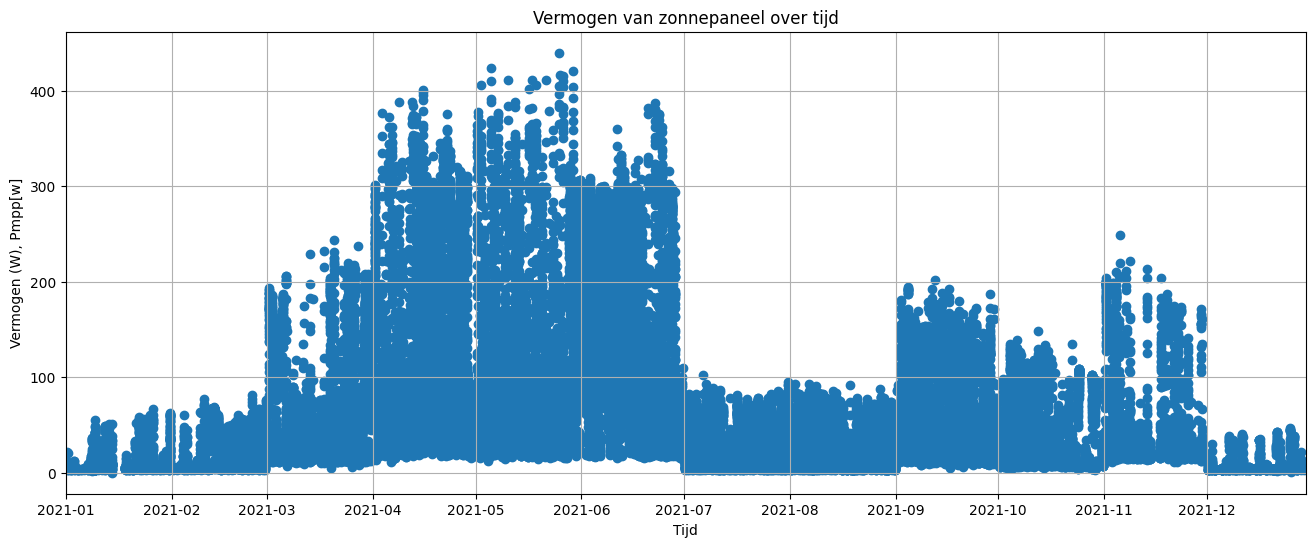

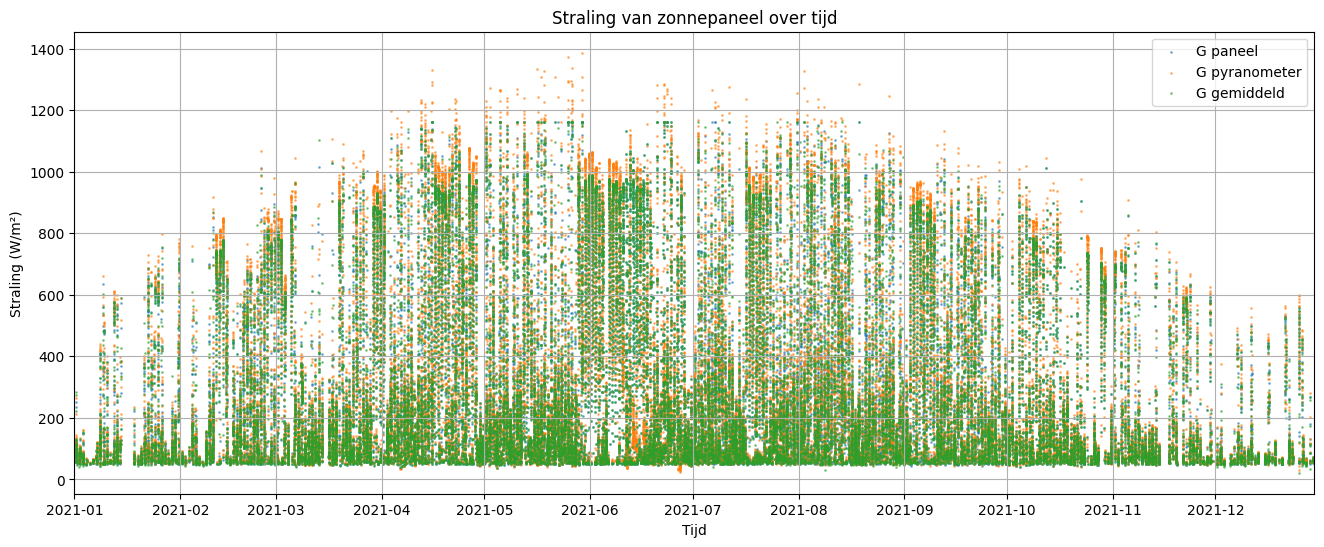

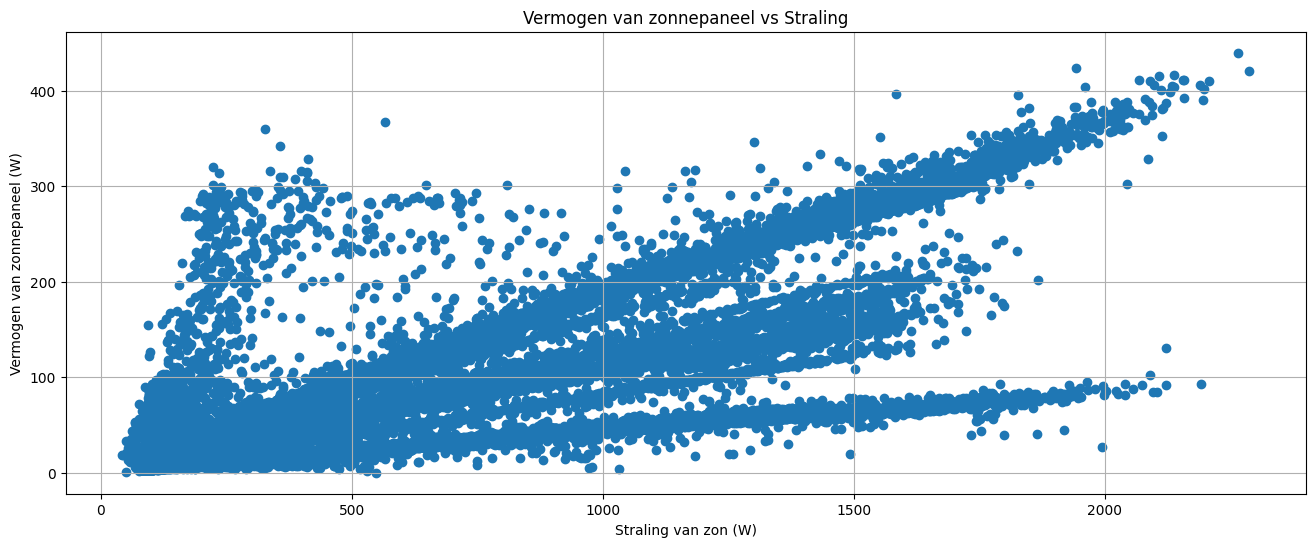

In [84]:
begin = pd.Timestamp('2021-01-01')
end = pd.Timestamp('2021-12-30')

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.scatter(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'])
plt.xlabel('Tijd')
plt.ylabel('Vermogen (W), Pmpp[w]')
plt.title('Vermogen van zonnepaneel over tijd')
plt.xlim(begin,end)
plt.grid()

plt.show()
plt.figure(figsize=(16, 6))
#plt.scatter(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'],alpha=0.5,s=0.1)
plt.scatter(synced_df.index, synced_df['G[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1,label='G paneel')
plt.scatter(synced_df.index, synced_df['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1, label='G pyranometer')
plt.scatter(synced_df.index, synced_df['average G [W/m²]_3 (Solarpanel curves)'],alpha=0.5, s=1, label='G gemiddeld')
plt.xlabel('Tijd')
plt.ylabel('Straling (W/m²)')
plt.title('Straling van zonnepaneel over tijd')
plt.xlim(begin,end )
plt.grid()
plt.legend()
plt.show()

begin_rendement = begin #pd.Timestamp('2021-05-1')
end_rendement = end #pd.Timestamp('2021-06-30')

maandenchecken = synced_df.loc[begin_rendement:end_rendement].copy()

plt.figure(figsize=(16, 6))
plt.scatter(maandenchecken['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)']*1.65,maandenchecken['Pmpp[W]_3 (Solarpanel parameters)'])
plt.xlabel('Straling van zon (W)')
plt.ylabel('Vermogen van zonnepaneel (W)')
plt.title('Vermogen van zonnepaneel vs Straling')
plt.grid()
plt.show()

In [32]:
print(type(synced_df.index))
synced_df.index = pd.to_datetime(synced_df.index)
print(type(synced_df.index))


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


<Figure size 1600x600 with 0 Axes>

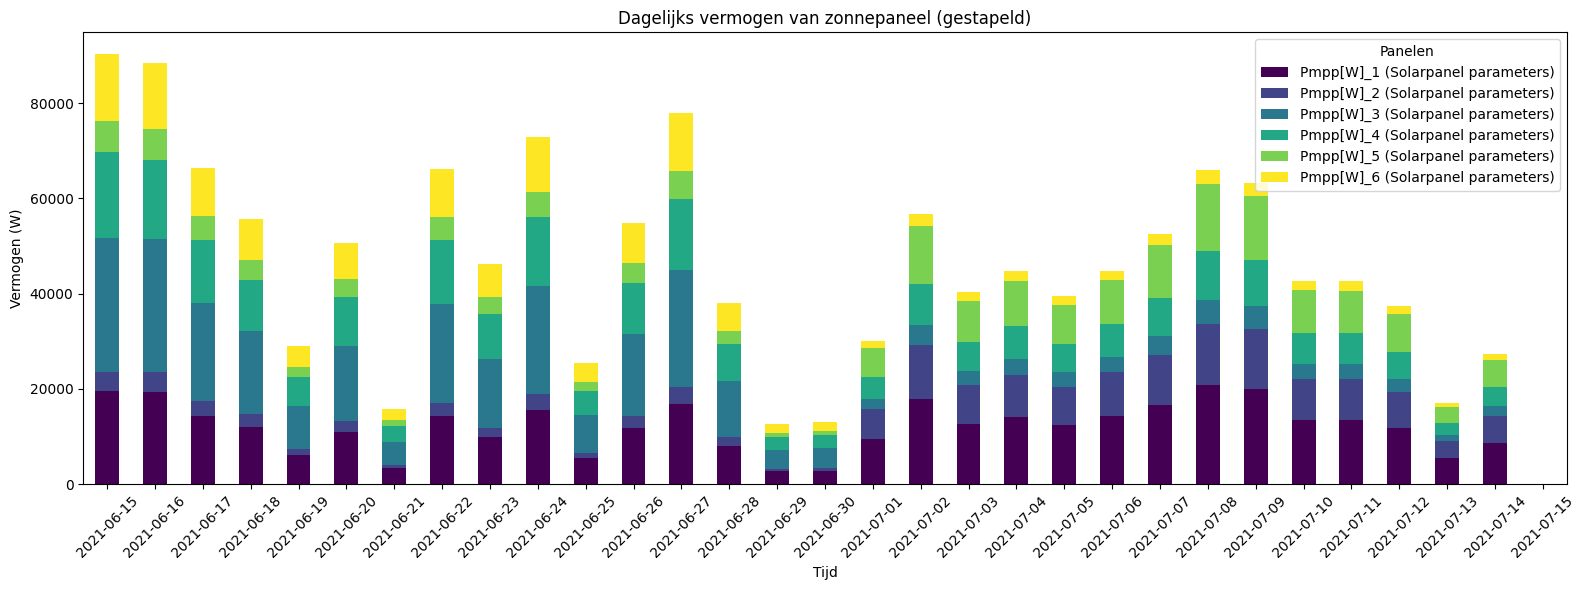

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the time range
begin = pd.Timestamp('2021-06-15')
end = pd.Timestamp('2021-07-15')

# Filter data within the time range
filtered_df = synced_df[(synced_df.index >= begin) & (synced_df.index <= end)]

# Resample to daily frequency and sum the "Vermogen" for each panel
daily_data = filtered_df.resample('D').sum()

# Extract panel columns dynamically
panel_columns = [col for col in daily_data.columns if 'Pmpp[W]' in col]

# Prepare the data for stacked bar plot
daily_data_panels = daily_data[panel_columns]

# Create a stacked bar chart
plt.figure(figsize=(16, 6))
daily_data_panels.plot(kind='bar', stacked=True, figsize=(16, 6), cmap='viridis')

# Customize the plot
plt.xlabel('Tijd')
plt.ylabel('Vermogen (W)')
plt.title('Dagelijks vermogen van zonnepaneel (gestapeld)')
plt.xticks(range(len(daily_data_panels.index)), daily_data_panels.index.strftime('%Y-%m-%d'), rotation=45)
plt.legend(title='Panelen')
plt.tight_layout()
plt.show()


In [37]:
filtered_daily_data = daily_data[(daily_data.iloc[:, 1:] != 0).any(axis=1)]


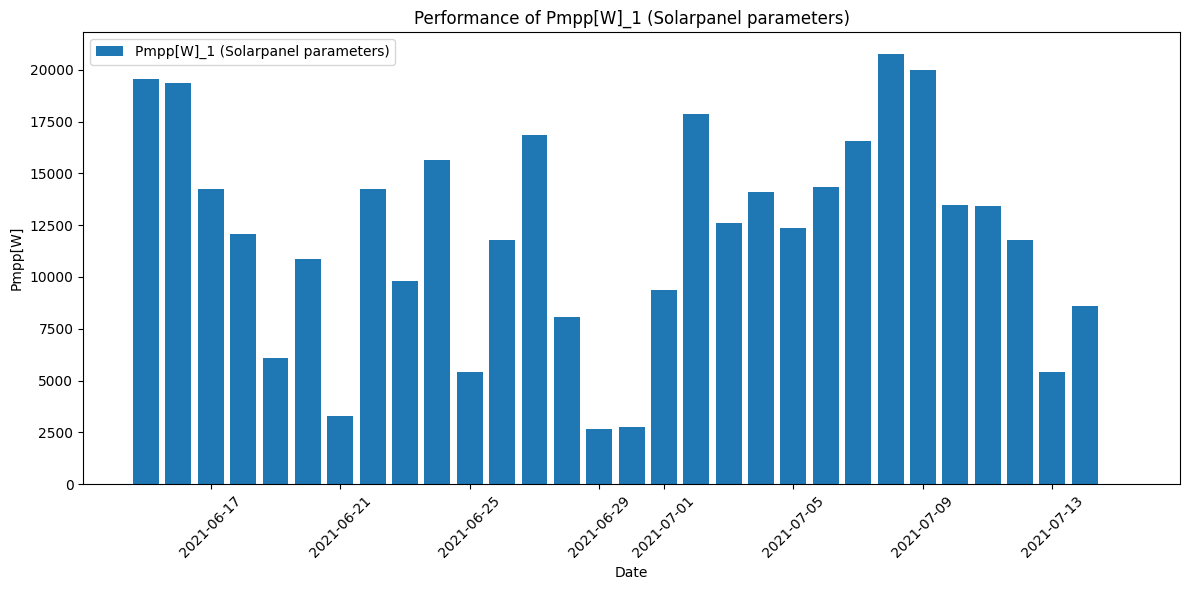

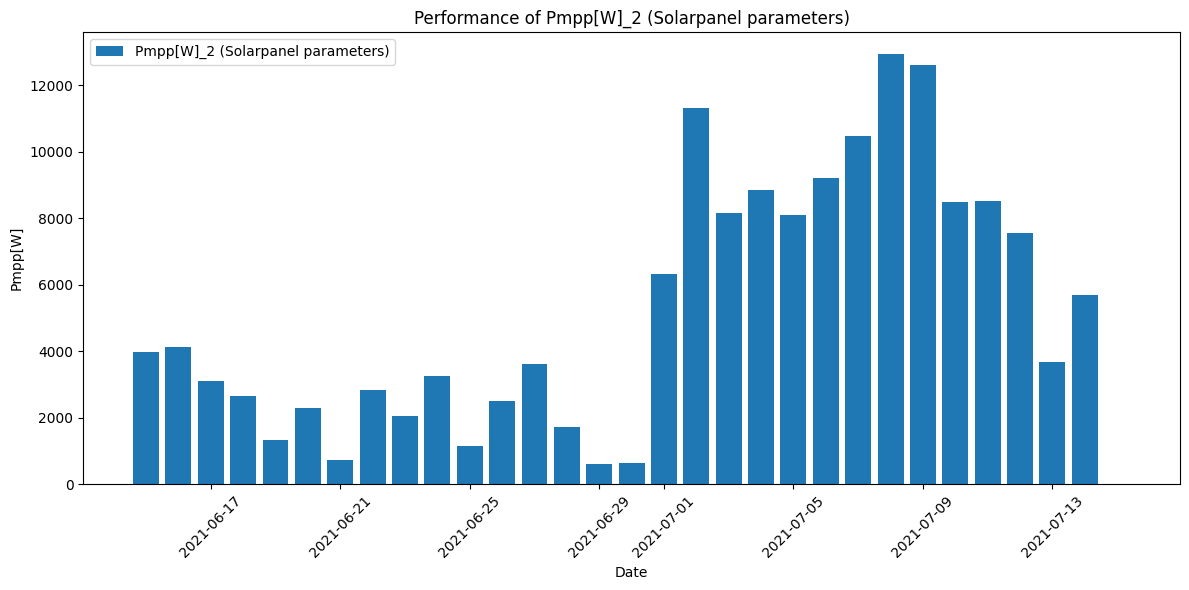

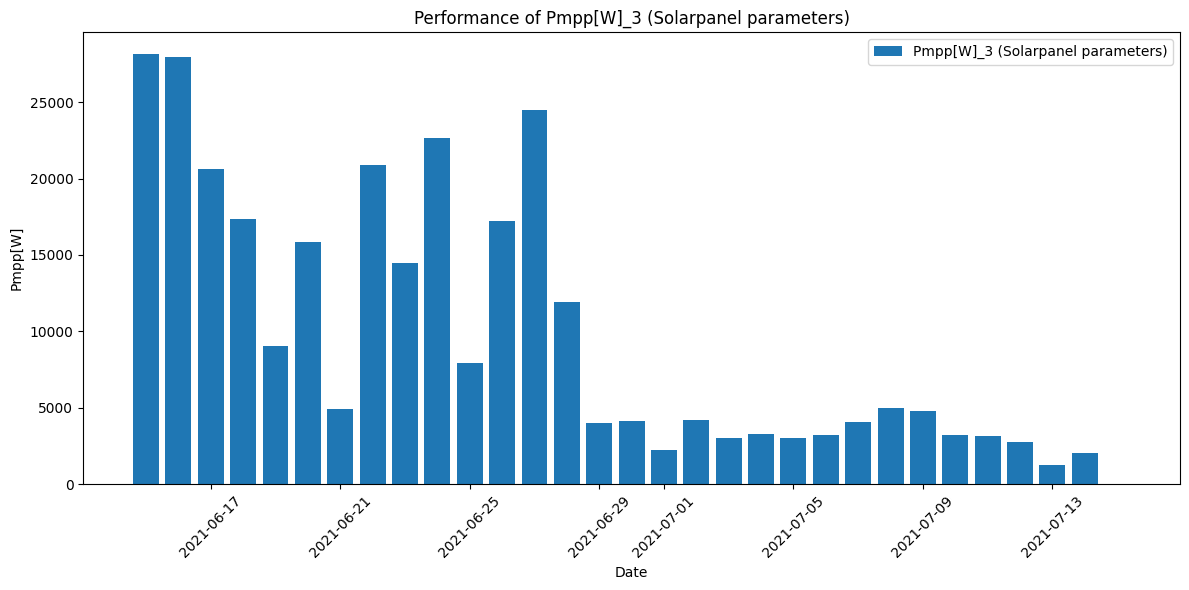

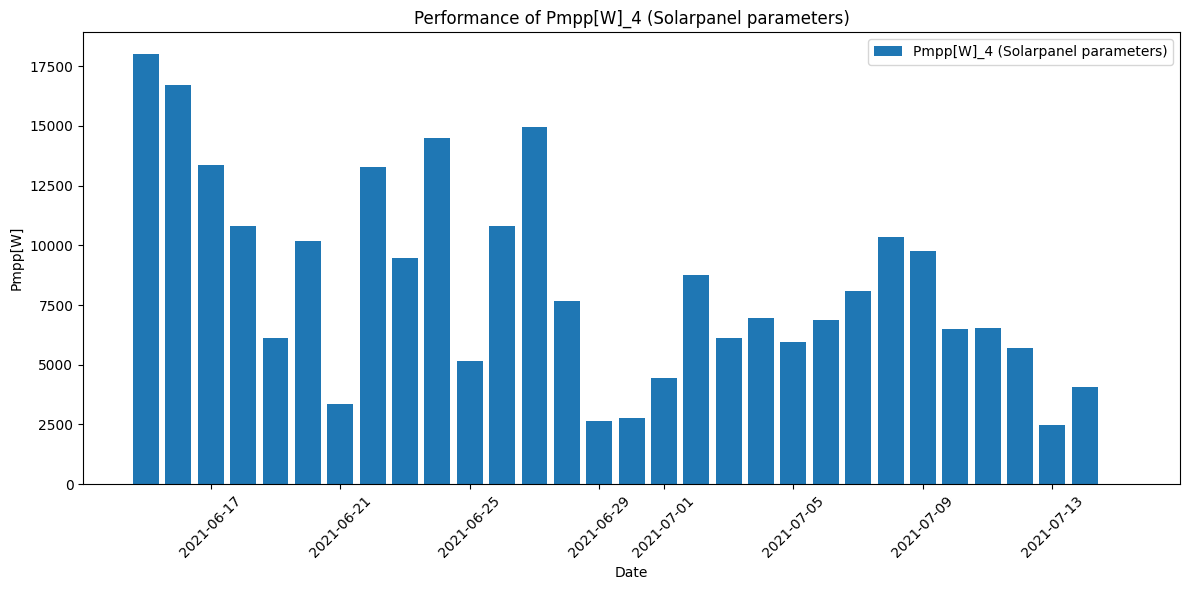

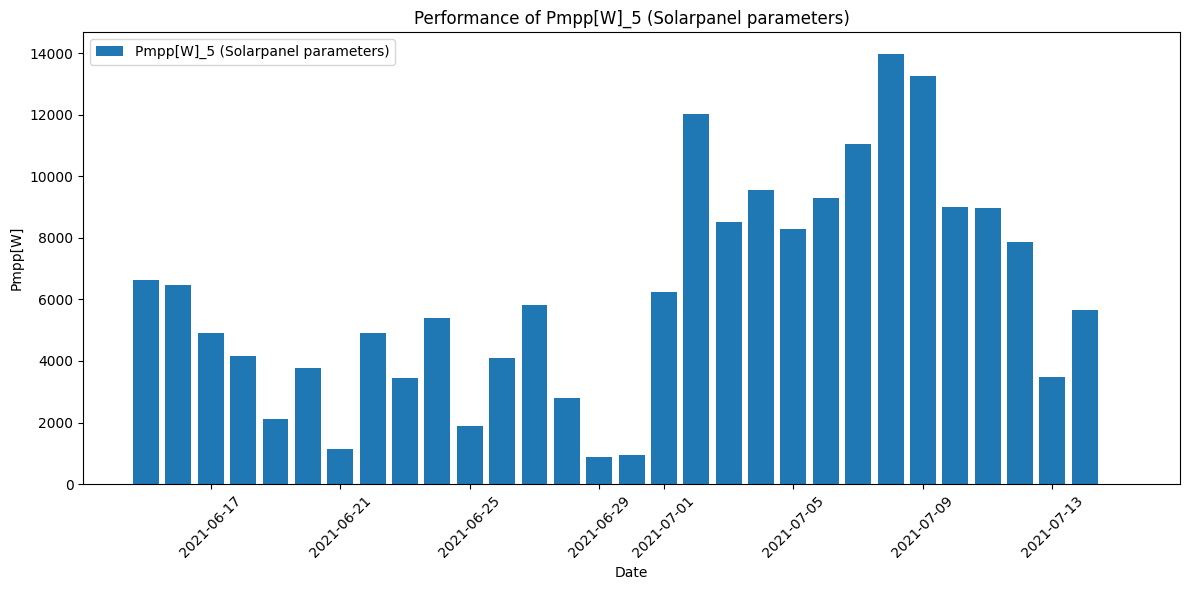

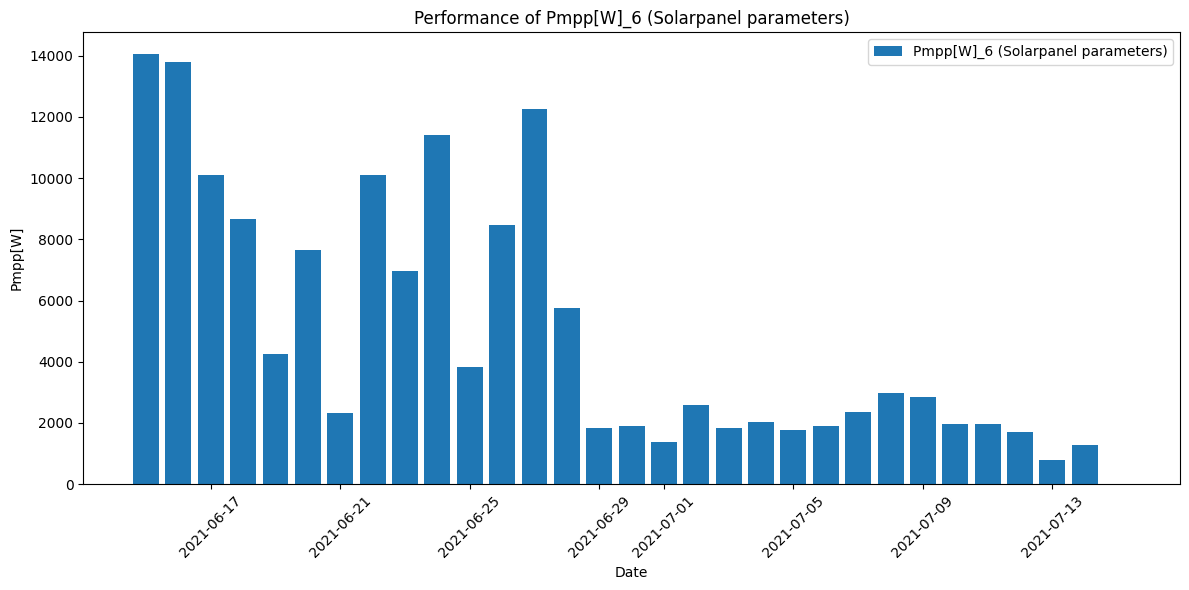

In [38]:
import matplotlib.pyplot as plt

panel_columns = [
    'Pmpp[W]_1 (Solarpanel parameters)', 'Pmpp[W]_2 (Solarpanel parameters)',
    'Pmpp[W]_3 (Solarpanel parameters)', 'Pmpp[W]_4 (Solarpanel parameters)',
    'Pmpp[W]_5 (Solarpanel parameters)', 'Pmpp[W]_6 (Solarpanel parameters)'
]

for panel in panel_columns:
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_daily_data.index, filtered_daily_data[panel], label=panel)
    plt.title(f'Performance of {panel}')
    plt.xlabel('Date')
    plt.ylabel('Pmpp[W]')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


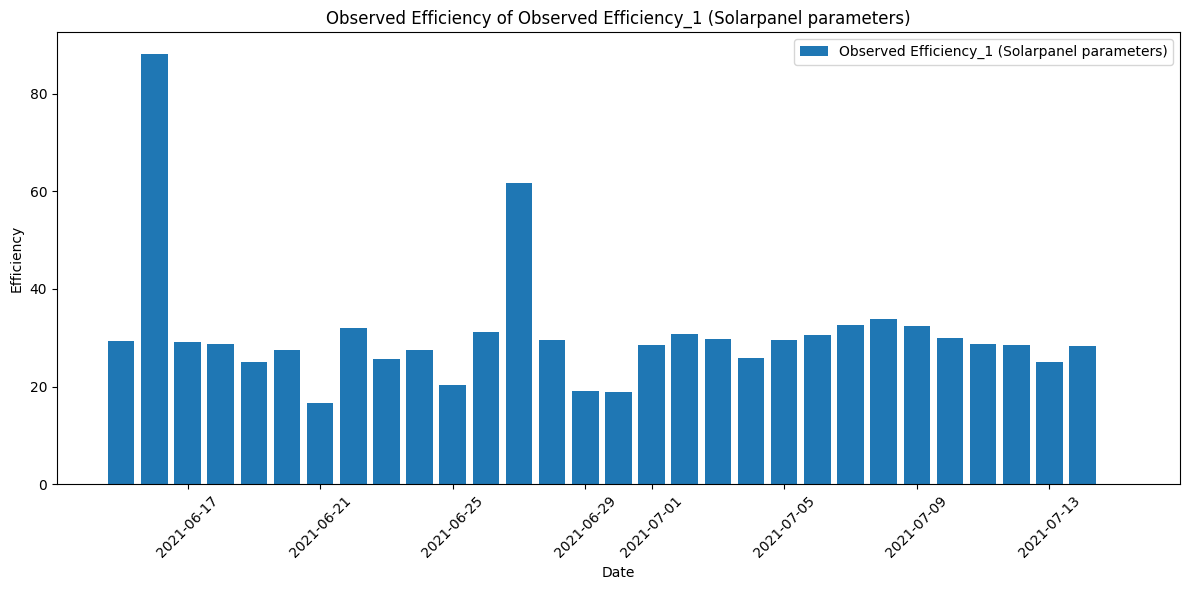

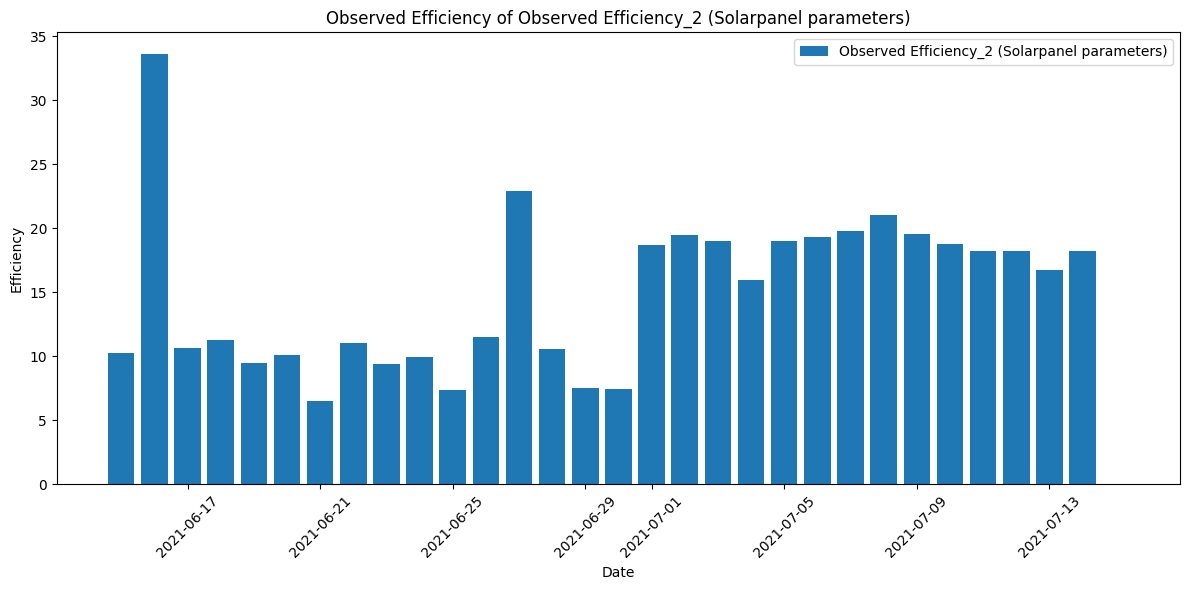

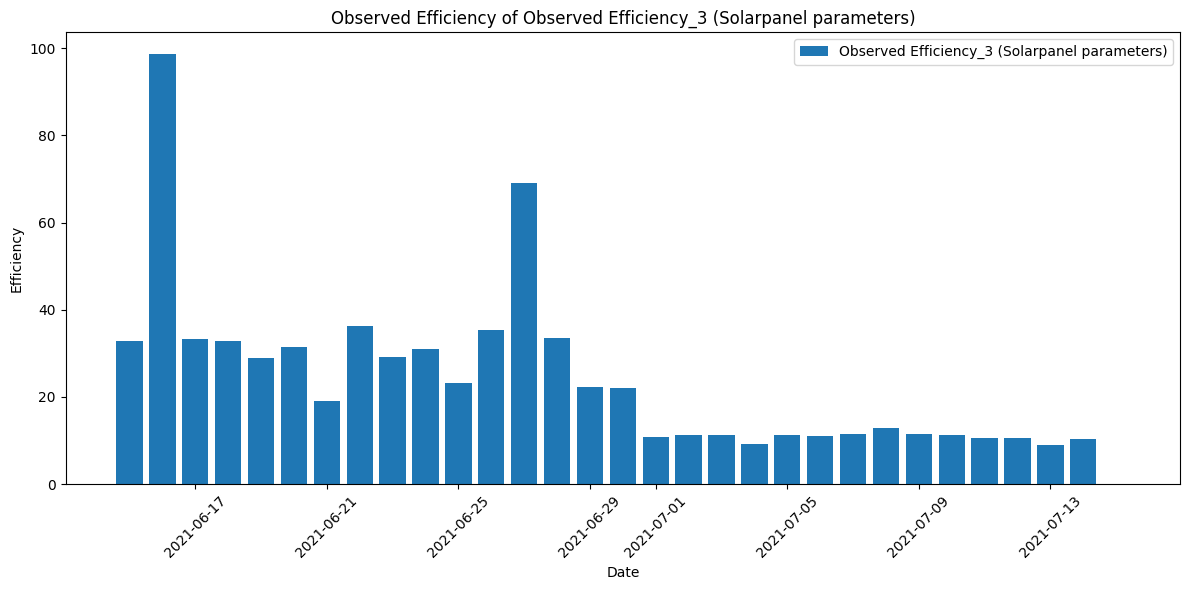

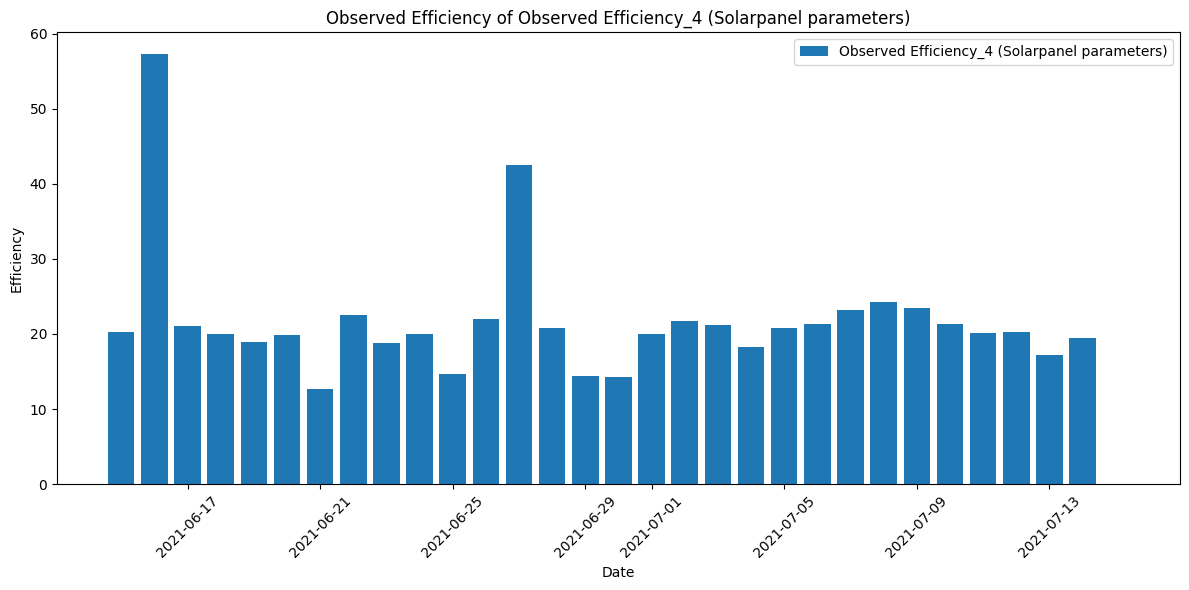

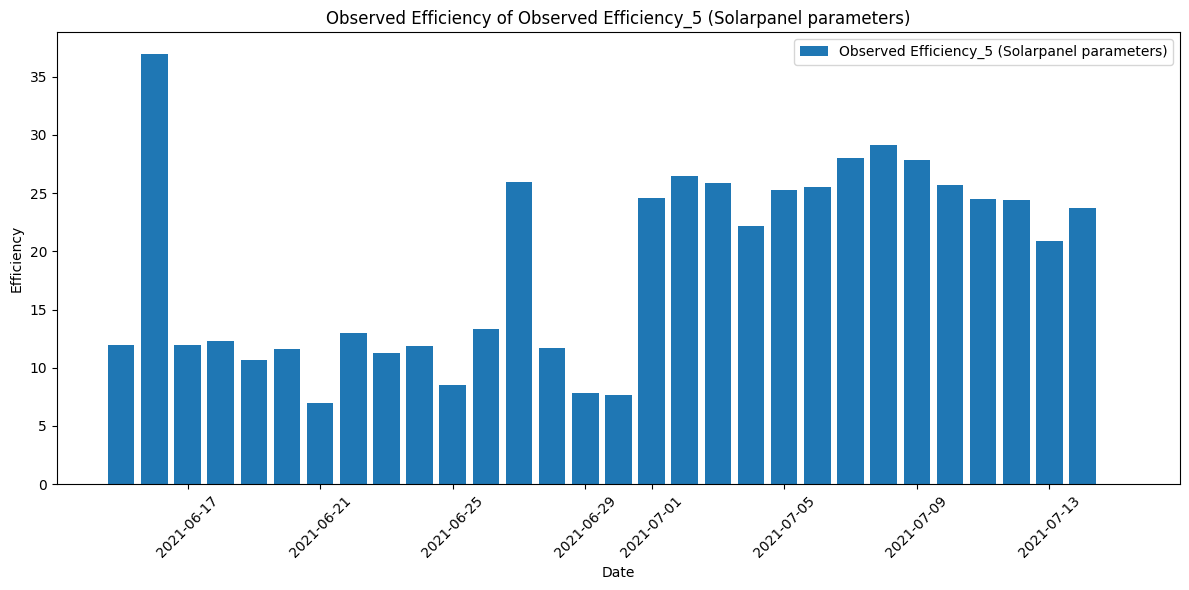

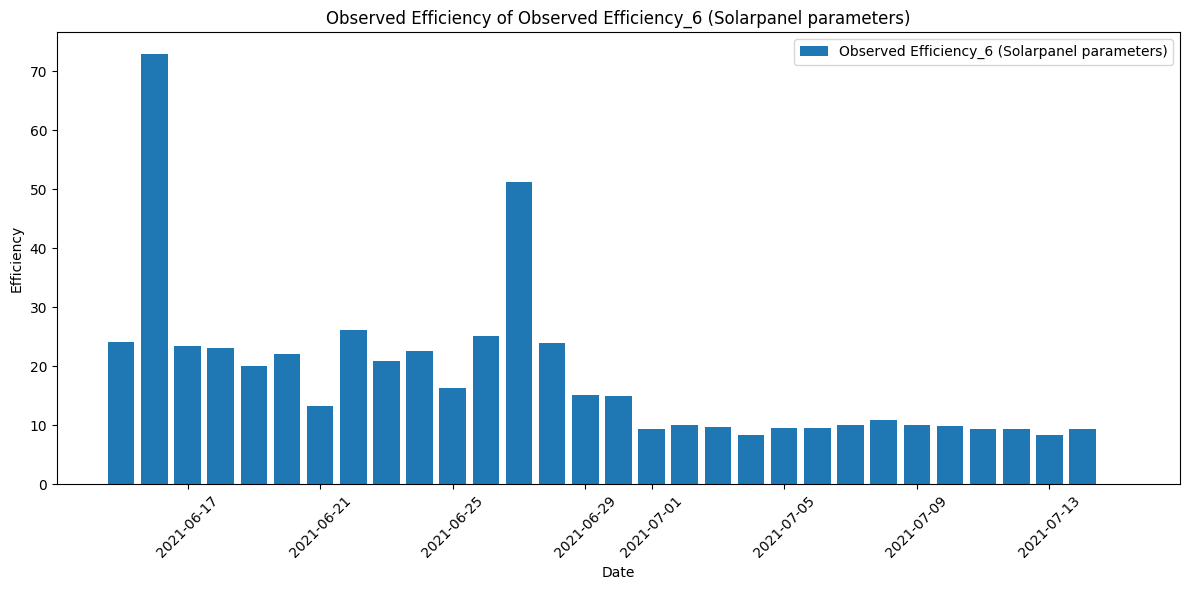

In [40]:
import matplotlib.pyplot as plt

efficiency_columns = [
    'Observed Efficiency_1 (Solarpanel parameters)',
    'Observed Efficiency_2 (Solarpanel parameters)',
    'Observed Efficiency_3 (Solarpanel parameters)',
    'Observed Efficiency_4 (Solarpanel parameters)',
    'Observed Efficiency_5 (Solarpanel parameters)',
    'Observed Efficiency_6 (Solarpanel parameters)',
]

for efficiency in efficiency_columns:
    plt.figure(figsize=(12, 6))
    plt.bar(filtered_daily_data.index, filtered_daily_data[efficiency], label=efficiency)
    plt.title(f'Observed Efficiency of {efficiency}')
    plt.xlabel('Date')
    plt.ylabel('Efficiency')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


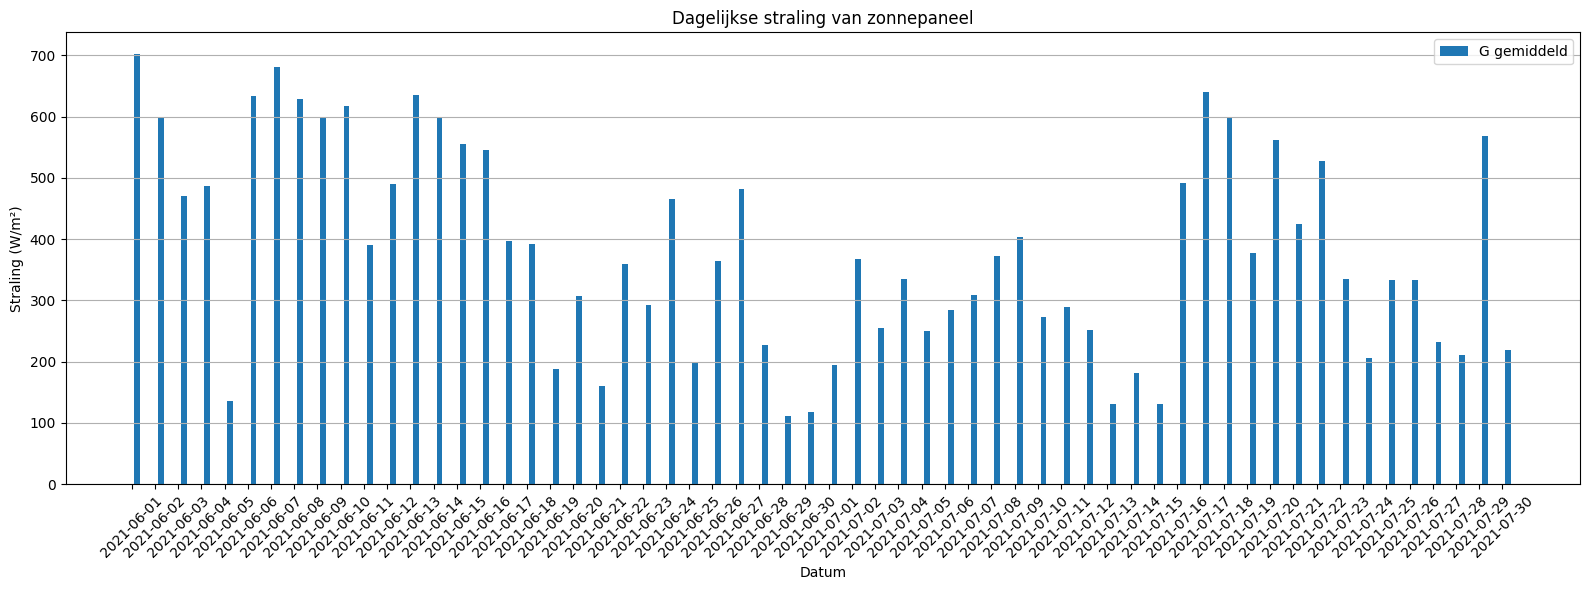

In [85]:
import matplotlib.pyplot as plt
import pandas as pd

begin = pd.Timestamp('2021-06-01')
end = pd.Timestamp('2021-07-30')

# Select only numeric columns
numeric_columns = synced_df.select_dtypes(include=['number'])

# Aggregate data to daily averages using only numeric columns
daily_data = numeric_columns.resample('D').mean()

# Filter the daily data for the given date range
filtered_daily_data = daily_data[(daily_data.index >= begin) & (daily_data.index <= end)]

# Define the variables to plot
variables = [
    'G[W/m²]_3 (Solarpanel parameters)',
    'G_pyranometer[W/m²]_3 (Solarpanel parameters)',
    'average G [W/m²]_3 (Solarpanel curves)'
]

# Define labels for the legend
labels = ['G paneel', 'G pyranometer', 'G gemiddeld']

# Bar width and offsets
bar_width = 0.25
x = range(len(filtered_daily_data.index))

plt.figure(figsize=(16, 6))

# Create bars for each variable
for i, var in enumerate(variables):
    if var in filtered_daily_data.columns:
        plt.bar(
            [p + i * bar_width for p in x],
            filtered_daily_data[var],
            bar_width,
            label=labels[i]
        )

# Format the plot
plt.xticks([p + bar_width for p in x], filtered_daily_data.index.strftime('%Y-%m-%d'), rotation=45)
plt.xlabel('Datum')
plt.ylabel('Straling (W/m²)')
plt.title('Dagelijkse straling van zonnepaneel')
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()
